In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import scipy.stats as stats
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


data = pd.read_csv('dataset-cleaning.csv', encoding='utf-8')

In [19]:
columns_categorical = data.select_dtypes(include=['object']).columns

label_encoders = {}
for col in columns_categorical:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

X = data.drop(columns=["CAUSAL_PARALIZACION"])
y = data["CAUSAL_PARALIZACION"]

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=42,
                                                    stratify=y)

In [20]:
param_grid_reduced = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_reduced = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                                   param_grid=param_grid_reduced,
                                   cv=3,
                                   scoring='accuracy',
                                   n_jobs=-1,
                                   verbose=1)

grid_search_reduced.fit(X_train, y_train)

best_model_reduced = grid_search_reduced.best_estimator_
best_params_reduced = grid_search_reduced.best_params_
best_score_reduced = grid_search_reduced.best_score_

y_pred_optimized_reduced = best_model_reduced.predict(X_test)
accuracy_optimized_reduced = accuracy_score(y_test, y_pred_optimized_reduced)
report_optimized_reduced = classification_report(y_test, y_pred_optimized_reduced)

print("Mejores hiperparámetros:", best_params_reduced)
print("Precisión promedio en validación cruzada:", best_score_reduced)
print("Precisión en el conjunto de prueba:", accuracy_optimized_reduced)
print("\nInforme de clasificación:\n", report_optimized_reduced)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Mejores hiperparámetros: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Precisión promedio en validación cruzada: 0.741198899642005
Precisión en el conjunto de prueba: 0.7669008965350134

Informe de clasificación:
               precision    recall  f1-score   support

           0       0.76      0.80      0.78       910
           1       0.79      0.78      0.78      2093
           2       0.73      0.72      0.72      1124

    accuracy                           0.77      4127
   macro avg       0.76      0.77      0.76      4127
weighted avg       0.77      0.77      0.77      4127



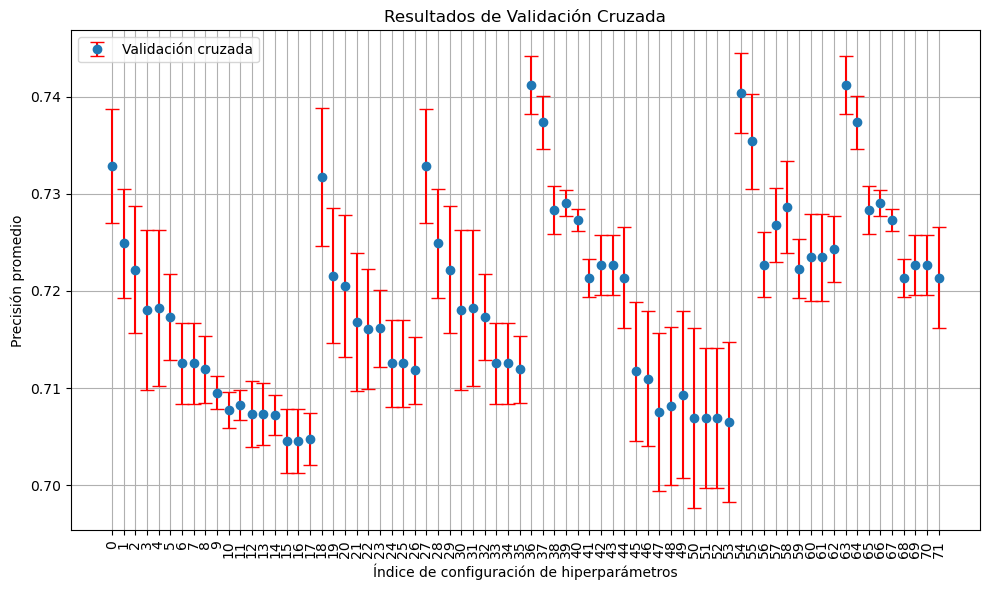

In [21]:
cv_results = grid_search_reduced.cv_results_

mean_scores = cv_results['mean_test_score']
std_scores = cv_results['std_test_score']

plt.figure(figsize=(10, 6))
plt.errorbar(range(len(mean_scores)), mean_scores, yerr=std_scores, fmt='o', ecolor='r', capsize=5, label="Validación cruzada")

plt.title('Resultados de Validación Cruzada')
plt.xlabel('Índice de configuración de hiperparámetros')
plt.ylabel('Precisión promedio')
plt.xticks(range(len(mean_scores)), labels=range(len(mean_scores)), rotation=90)
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

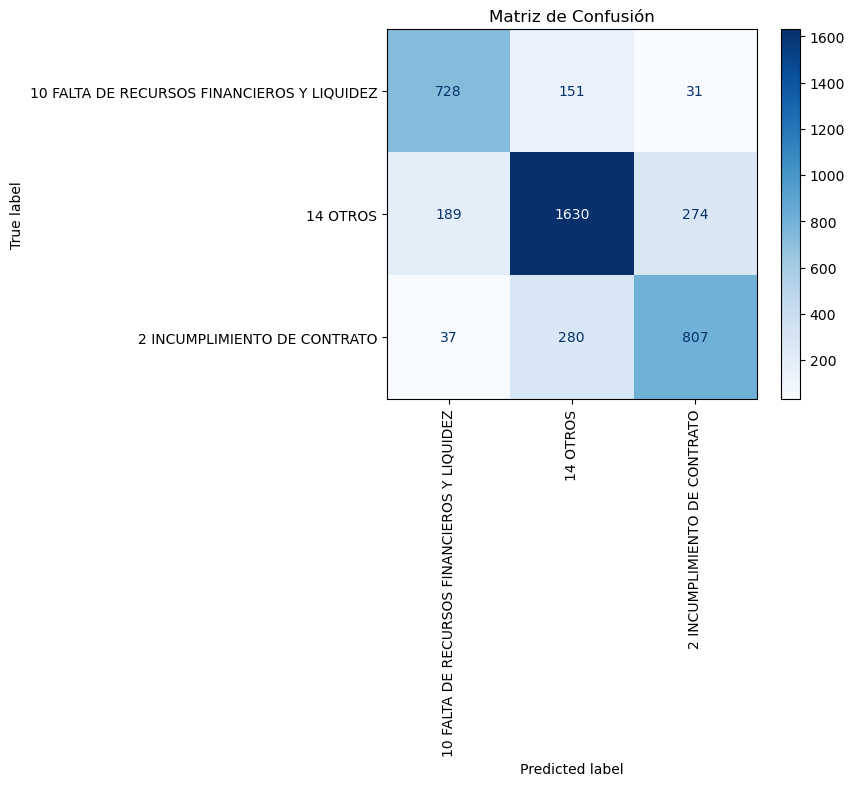

In [22]:
conf_matrix = confusion_matrix(y_test, y_pred_optimized_reduced)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=label_encoders['CAUSAL_PARALIZACION'].classes_)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.xticks(rotation=90)
plt.title("Matriz de Confusión")
plt.show()

In [23]:
correlation, _ = stats.pearsonr(y_test, y_pred_optimized_reduced)

mae = mean_absolute_error(y_test, y_pred_optimized_reduced)

rmse = np.sqrt(mean_squared_error(y_test, y_pred_optimized_reduced))

rae = mae / np.mean(np.abs(y_test - np.mean(y_test)))

rrse = rmse / np.sqrt(np.mean((y_test - np.mean(y_test)) ** 2))

instances = len(y_test)

{
    "Correlation Coefficient": correlation,
    "Mean Absolute Error (MAE)": mae,
    "Root Mean Squared Error (RMSE)": rmse,
    "Relative Absolute Error (RAE)": rae,
    "Root Relative Squared Error (RRSE)": rrse,
    "Instances": instances
}

{'Correlation Coefficient': np.float64(0.714631015946365),
 'Mean Absolute Error (MAE)': 0.24957596316937242,
 'Root Mean Squared Error (RMSE)': np.float64(0.531535212923983),
 'Relative Absolute Error (RAE)': np.float64(0.4832429632768951),
 'Root Relative Squared Error (RRSE)': np.float64(0.759209636155623),
 'Instances': 4127}

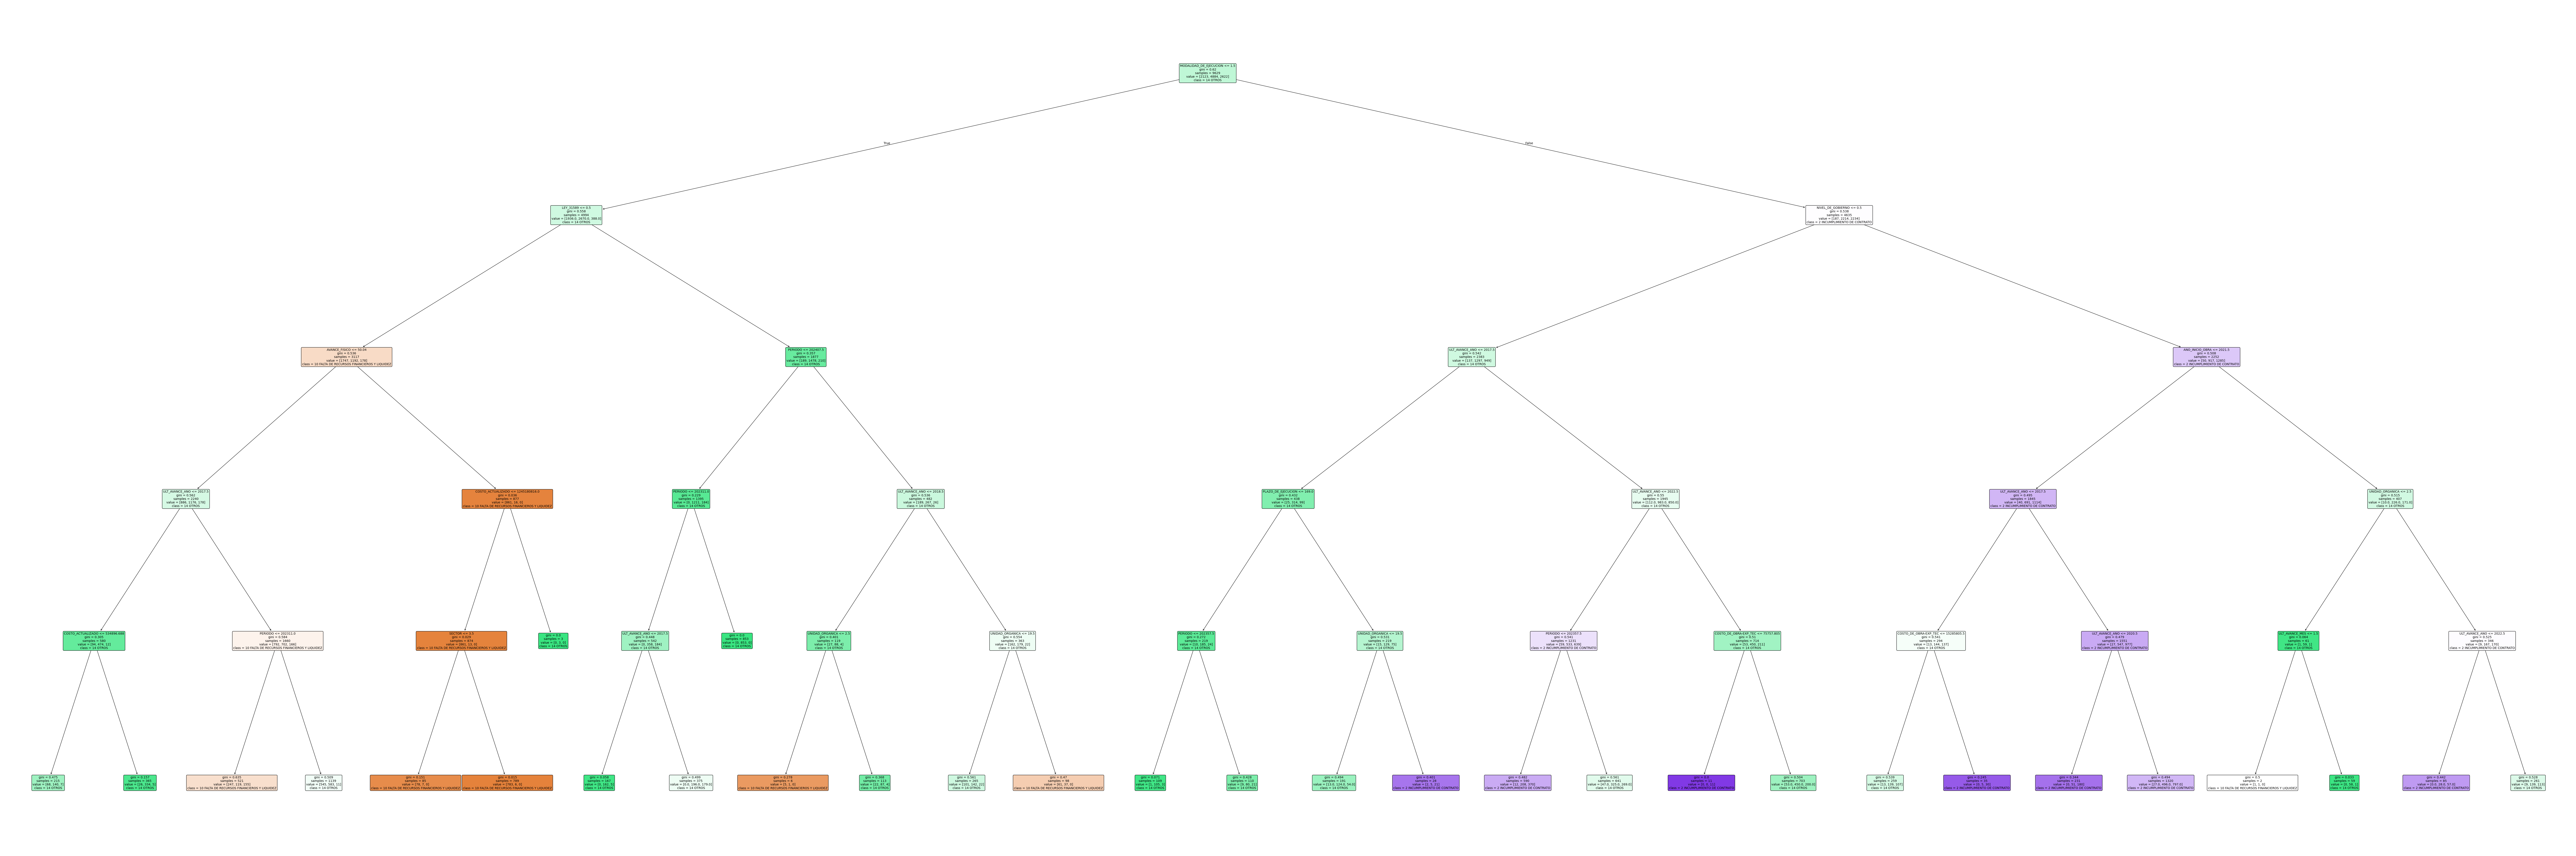

In [14]:
visual_model = DecisionTreeClassifier(max_depth=5, random_state=42)
visual_model.fit(X_train, y_train)

plt.figure(figsize=(150, 50))

plot_tree(
    visual_model,
    feature_names=X.columns,
    class_names=label_encoders["CAUSAL_PARALIZACION"].classes_,
    filled=True,
    rounded=True,
    fontsize=10
)

# Mostrar el gráfico
plt.savefig('tree.png', dpi=150, bbox_inches='tight')
plt.show()